# Portfolio assignment week 7

## 1. Bagging vs Boosting
The scikit-learn library provides several options for bagging and boosting. It is possible to create your own boosting model based on a base model. For instance, you can create a tree based bagging model. In addition, scikit-learn provides AdaBoost. For XGBoost it is best to use the xgboost library.

Based on the theory in the [accompanying notebook](../Exercises/E_BAGGING_BOOSTING.ipynb), create a bagging, boosting and dummy classifier. Test these classifiers on the [breast cancer dataset](https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset). Go through the data science pipeline as you've done before:

1. Try to understand the dataset globally.
2. Load the data.
3. Exploratory analysis
4. Preprocess data (skewness, normality, etc.)
5. Modeling (cross-validation and training). (**Create several bagging classifiers with different estimators**.)
6. Evaluation (**Use the evaluation methods as described in the previous lessons. Then compare the different models**.)
7. Try to understand why some methods perform better than others. Try different configurations for your bagging and boosting models.

In [296]:
# import modules:
import pandas as pd
import yaml


In [297]:
# load the data
with open('config.yaml', 'r') as conf:
    config = yaml.load(conf, yaml.SafeLoader)

bc_data = pd.read_csv(config['breast_cancer_data'])

bc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [298]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# alterations to the dataframe, changing obj to str
bc_data.diagnosis = bc_data.diagnosis.astype(str)
# check the sample types
print(f'Unique types: {bc_data.diagnosis.unique()}')
# check missing values
print(f'missing values: {bc_data.isnull().values.sum()}')
# scale/normalize the data
scaled_data = sc.fit_transform(bc_data.iloc[:,2:])

Unique types: ['M' 'B']
missing values: 0


In previous assignments it was seen that the values of some features were somewhat skewed however it did not seem to affect classification that much. If in this instance it seems necessary, log transformation on some columns could be done. 

In [299]:
from sklearn.model_selection import train_test_split

def from_b_m_to_bin(val):
    match val:
        case 'M':
            return 1
        case 'B':
            return 0
        case _:
            return 'why?'

#split the data in test and train sets
X = scaled_data
y = [from_b_m_to_bin(val) for val in bc_data.diagnosis]

#Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [300]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier

bag_clf = BaggingClassifier(estimator=SVC(),n_estimators=10,
                             random_state=42)
xgb_clf = XGBClassifier()

bag_clf.fit(X_train,y_train)
xgb_clf.fit(X_train,y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [301]:
from sklearn.metrics import accuracy_score

In [302]:
import time
x_pred = xgb_clf.predict(X_test)
b_pred = bag_clf.predict(X_test)

def get_score(test_y, pred_y):
    false_pred = 0
    for p,y in zip(pred_y, test_y):
        if p != y:
            false_pred += 1
    return 1 - false_pred / len(pred_y)


acc_x = get_score(y_test, x_pred)
acc_b = get_score(y_test, b_pred)

print(f'Accuracy xgboost: {acc_x:0.6}'
      f'\nAccuracy bag: {acc_b:0.6}')




Accuracy xgboost: 0.982456
Accuracy bag: 0.982456


In [303]:
bag_boost = bag_clf = BaggingClassifier(estimator=XGBClassifier(),
                                       n_estimators=10,
                                        random_state=42)
bag_boost.fit(X_train,y_train)
bag_boost_pred = bag_boost.predict(X_test)

acc_bb = get_score(y_test, bag_boost_pred)

print(acc_bb)


0.9473684210526316


Combining bagging and boosting probably causes overfitting.
At least in this relatively small dataset. 

Now lets compare different estimators with the bagging classifier

In [304]:
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import IsolationForest
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression


# own modules
from junk_estimator import JunkEstimator

est_list = [SVC, LinearSVC, IsolationForest, tree.DecisionTreeClassifier,
            GaussianNB, LogisticRegression, JunkEstimator]
#est_list = [JunkEstimator(mode='Neumann'),JunkEstimator()]
clf_list = [BaggingClassifier(estimator=est(), n_estimators=10, random_state=42) 
                for est in est_list]

clf_list.append(BaggingClassifier(estimator=JunkEstimator(mode="Neumann"), n_estimators=10, random_state=42))

for clf in clf_list:
    clf.fit(X_train,y_train)

clf_scores = [get_score(clf.predict(X_test),y_test) for clf in clf_list]

clf_scores



[0.9824561403508771,
 0.9385964912280702,
 0.4122807017543859,
 0.9649122807017544,
 0.9210526315789473,
 0.956140350877193,
 0.5526315789473684,
 0.5789473684210527]

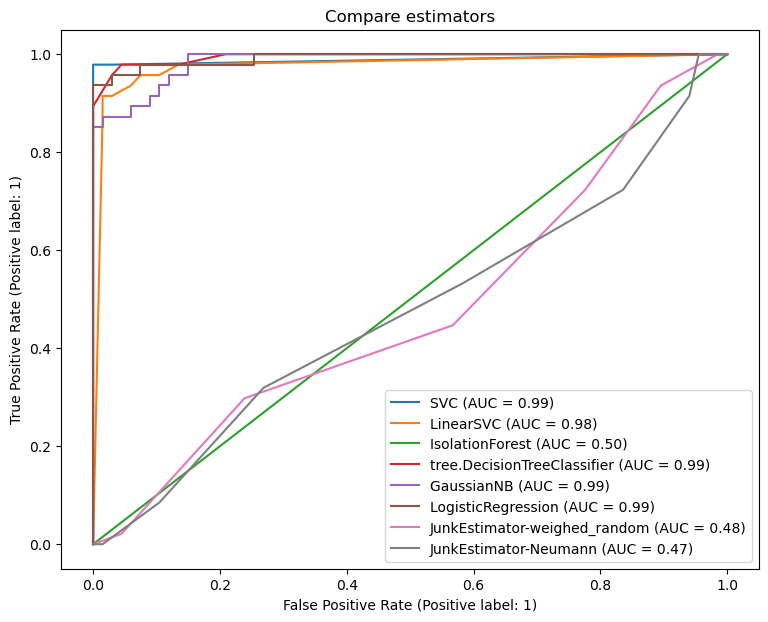

In [305]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(9,7))

names = ["SVC", "LinearSVC", "IsolationForest", "tree.DecisionTreeClassifier",
            "GaussianNB", "LogisticRegression", "JunkEstimator-weighed_random","JunkEstimator-Neumann"]

fig_list = []
for clf in clf_list:
    fig_list.append(RocCurveDisplay.from_estimator(clf,X_test,y_test))
    plt.close()

for fig,name in zip(fig_list, names):
    fig.plot(ax=ax, name=name)
    ax.set_title("Compare estimators")

plt.show() 

So what does this prove? 

Well using a estimator based on a fair coin flip ("Neumann") or weighed random chance consistantly outperforms 0.5 based on accuracy score. However taking in account the AUC, looking at true and false positives it performs as bad as expected. 